### CNN/DailyMail 데이터셋

In [1]:
from datasets import load_dataset

dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0")
print(f"특성: {dataset['train'].column_names}")

C:\Users\knuyh\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


특성: ['article', 'highlights', 'id']


In [2]:
sample = dataset["train"][1]
print(f"""기사 (500개 문자 발췌, 총 길이: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f'\n요약 (길이: {len(sample["highlights"])}):')
print(sample["highlights"])

기사 (500개 문자 발췌, 총 길이: 6195):
Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the GSA's Kansas City, Missouri, office, a CNN investigation has found. It cost more than $24,000 for the business development specialist to travel to and from the mainland United States over the past year. He is among several hundred GSA "virtual" workers who also travel to various conferences and their hom

요약 (길이: 240):
The employee in agency's Kansas City office is among hundreds of "virtual" workers .
The employee's travel to and from the mainland U.S. last year cost more than $24,000 .
The telecommuting program, like all GSA practices, is under review .


긴 기사는 트랜스포머 모델에 문제를 일으켜, 이를 처리하는 표준적이면서 가장 단순한 방법은 모델의 문맥 크기에 맞춰 텍스트를 자르는 것

### 텍스트 요약 파이프라인

In [3]:
sample_text = dataset["train"][1]["article"][:2000]  # 입력 텍스트 2000자로 제한
# 딕셔너리에 각 모델이 생성한 요약 저장
summaries = {}

In [4]:
# 요약 문장은 줄바꿈으로 나눔
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\knuyh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

* 요약 기준 모델
기사를 요약하는 일반적인 기준 모델은 단순히 기사에서 맨 처음 문장 세 개를 선택하는 것

In [6]:
def three_sentence_summary(text) :
    return '\n'.join(sent_tokenize(text)[:3])

In [7]:
summaries['baseline'] = three_sentence_summary(sample_text)

* GPT2

In [8]:
from transformers import pipeline, set_seed

pipe = pipeline("text-generation", model="gpt2-large")

gpt2_query = sample_text + "\nTL;DR:\n" # 긴 포스트 짧게 요약할 때, '너무 길어 읽지 않았다'는 약어
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


* T5  
모델의 입력 포맷은 'translate English to German : < TEXT >'  
pipeline() : T5 로드, 이 함수는 립력을 텍스트 - 투 - 텍스트 포맷으로 처리하므로 앞에 'summarize' 붙일 필요 없다.

In [9]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

* BART  
인코더-디코더 구조 사용하는 모델로, 손상된 입력을 재구성하도록 훈련됨

In [10]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

* PEGASUS  
인코더-디코더 트랜스포머로, 여러 문장으로 구성된 텍스트에서 마스킹된 문장 예측하는 사전 훈련 목표로 훈련됨

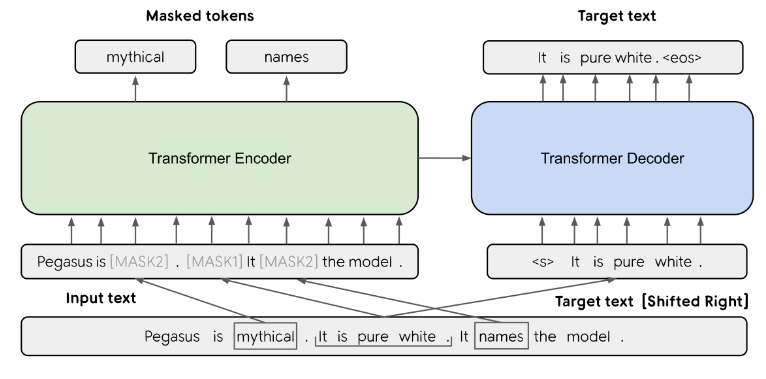

In [11]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n") 
# 줄바꿈하는 특수 토큰이 있어 sent_tokenize() 사용 X

C:\Users\knuyh\anaconda3\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 요약 결과 비교하기
* GPT-2 : 데이터셋에서 전혀 훈련되지 않음
* T5 : 여러 작업 중의 하나로 이 작업을 위해 미세 튜닝됨
* BART, PEGASUS : 이 작업만을 위해 미세 튜닝됨

In [12]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
The employee in agency's Kansas City office is among hundreds of "virtual" workers .
The employee's travel to and from the mainland U.S. last year cost more than $24,000 .
The telecommuting program, like all GSA practices, is under review .

BASELINE
Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the GSA's Kansas City, Missouri, office, a CNN investigation has found.
It cost more than $24,000 for the business development specialist to travel to and from the mainland United States over the past year.
He is among several hundred GSA "virtual" workers who also travel to various conferences and their home offices, costing the agency millions of dollars over the past three years.

GPT2
- Hawaii Virtual Workers have an amazing vacation that goes on for nearly 6 months
- They have a telecommuting allowance that costs them hundreds of thou

* GPT2 : 텍스트를 요약하는 대신 등장인물 요약
    * 진짜 요약을 생성하도록 명시적으로 훈련되지 않았기에 종종 사실을 지어내거나 환상 만들어냄
* PEGASUS : 정답 요약과 가장 비슷

### 생성된 텍스트 품질 평가하기
#### BLEU
* 생성된 텍스트에서 얼마나 많은 토큰이 참조 텍스트 토큰과 완벽하게 똑같이 정렬됐는지 확인하는 대신, 단어 또는 n-그램 체크
* 정밀도 근간으로 하는 지표
* 참조 텍스트에 있는 단어가 생성된 텍스트에 얼마나 자주 등장하는지 카운트한 후 생성된 텍스트 길이로 나눔
    * 생성된 텍스트에 동일단어 반복되고 참조 텍스트에 등장하면 문제
    * 따라서 변화를 주어, 단어를 참조 텍스트에 등장한 횟수만큼만 카운트
* 단점
    * 동의어를 고려하지 않음
    * 토큰화된 텍스트 기대함
    * SacreBLEU : 토큰화 단계 내재화해 문제 해결

In [13]:
import evaluate

bleu_metric = evaluate.load("sacrebleu")

In [14]:
import pandas as pd
import numpy as np

# add : 샘플 하나 추가
# add_batch : 배치 전체 추가

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0) 
# bleu는 참조 매개변수를 전달해 n-그램이 없어도 점수가 0이 되지 않음 -> 해당 기능 끔(smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


1-그램의 정밀도 = 2/6  
2/3/4-그램의 정밀도 = 0

In [15]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


1-그램의 정밀도 = 1  
4-그램의 경우 [the, cat, is, on] / [cat, is, on, mat] 에서 두 번째 맞추지 못했으므로 정밀도 = 0.5

* BLEU는 텍스트 평가에 널리 사용 (주로 번역)

#### ROUGE
* 중요한 정보가 생성된 텍스트에 모두 포함되어야 하므로 높은 재현율 선호
* 높은 재현율이 정밀도보다 훨씬 더 중요한 요약 같은 애플리케이션을 위해 개발
* 생성된 텍스트와 참조 텍스트에서 여러 가지 n-그램이 얼마나 자주 등장하는지 비교한다는 점에서 BLEU와 비슷
* ROUGE는 참조 텍스트에 있는 n-그램이 생성된 텍스트에 얼마나 많이 등장하는지도 확인
* ROUGE-L : 문장마다 점수 계산해 요약에 대해 평균한 점수
* ROUGE-Lsum : 전체 요약에 대해 계산한 점수

In [16]:
rouge_metric = evaluate.load("rouge")

In [17]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.432836,0.196970,0.223881,0.298507
gpt2,0.230088,0.036036,0.141593,0.159292
t5,0.376471,0.120482,0.235294,0.376471
bart,0.426966,0.229885,0.247191,0.404494
pegasus,0.464646,0.206186,0.202020,0.343434


GPT-2 성능이 가장 낮고, PEGASUS가 가장 좋다.

### CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

In [18]:
rouge_metric = evaluate.load("rouge", cache_dir=None)

In [19]:
# 처음 세 문장 사용하는 기준 모델 성능 평가
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score

In [20]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

# GPT2보다 점수가 좋다.

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.38216,0.166896,0.245206,0.349356


In [21]:
# PEGASUS 모델 성능 평가
from tqdm import tqdm
import torch

# 작은 배치로 나눔
def chunks(list_of_elements, batch_size) :
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16,# device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")
        
        # 빔 서치로 요약 생성
        summaries = model.generate(input_ids=inputs["input_ids"],
                         attention_mask=inputs["attention_mask"],
                         length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|                                                                                          | 0/125 [00:00<?, ?it/s]

손실과 각 토큰의 정확도는 ROUGE 점수와 일정 수준 관련성이 없다.  
ROUGE 점수는 디코딩 전략과 밀접하게 관련

### 요약 모델 훈련하기

In [ ]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

* SAMSum에서 PEGASUS 평가하기

In [ ]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("요약:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

In [ ]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

CNN/DailyMAil 데이터셋이 SAMSum 과 크게 다르기에 훌륭하지 않은 결과  
* PEGASUS에서 미세 튜닝하기

In [ ]:
# 입력과 출력 길이의 분포
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

대부분의 대화는 100-200개 토큰으로 구성되며 CNN/DailyMail 기사보다 훨씬 짧다.  
요약도 20-40개 토큰(평균 트윗 길이)으로 구성되며 훨씬 더 짧다.

In [ ]:
# 데이터셋 토큰화
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)
    
    # 일부 모델은 디코더 입력에 특수 토큰 필요 (인코더와 디코더 입력의 토큰화 구별 중요)
    # 토크나이저가 디코더를 위한 토큰화임을 인지하고 그에 따라 시퀀스 처리
    with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(text_target=example_batch["summary"], max_length=128,
                                    truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

[데이터 콜레이터]  
요약 작업에서는 입력을 쌓을 뿐만 아니라 디코더 쪽의 타깃도 준비  
  
PEGASUS는 인코더-디코더 트랜스포머이고, 따라서 고전적인 seq2seq 구조  
seq2seq 구조에선 디코더에 '**티처 포싱(teacher forcing)**' 적용 : 디코더가 인코더 출력 외에 한 토큰이 이동된 레이블로 구성된 입력 토큰 받음, 따라서 다음 토큰을 위한 예측을 만들 때 디코더는 한 토큰이 이동된 정답을 입력으로 받음

In [ ]:
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

한 스텝 이동했으므로 디코더는 이전 스텝의 정답 레이블만 보며 현재와 미래 레이블을 보지 못함  
디코더는 현재와 미래의 모든 입력을 마스킹하는 마스크드 셀프 어텐션 갖기에 이동시키는 것으로 충분

In [ ]:
# 배치 준비 시 레이블을 한 스텝 오른쪽으로 이동시켜 디코더 입력 생성
# 그런 다음 레이블에 있는 패딩 토큰을 -100으로 설정해 손실 함수가 무시하도록 설정
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)
    # 모델이 매우 크므로 배치크기를 1로 지정하는데, 배치 크기가 너무 작으면 수렴하지 않음
    # 문제 해결을 위해 그레이디언트 누적 기술 사용
    # 큰 배치의 그레이디언트 한 번에 계산하는 대신 작은 배치를 만들고 그레이디언트 누적

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

In [ ]:
trainer.push_to_hub("Training complete!")

미세 튜닝하지 않은 모델에 비해 ROUGE 점수 향상

* 대화 요약 생성하기

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="rlaalswl7288/pegasus-samsum")

print("대화:")
print(sample_text)
print("\n참조 요약:")
print(reference)
print("\n모델 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])